In [10]:
import numpy as np
import pandas as pd
import plotly.express as px

In [55]:
df = pd.read_csv('./30751_CR1000x_Hourly.dat', skiprows = 1)
units = df.iloc[0]
stat_meth = df.iloc[1]
data = df.iloc[2:]
data = data.set_index('TIMESTAMP')

# # Converting the index as date
data.index = pd.to_datetime(data.index)
data.index = data.index.tz_localize('America/Denver')

#converting to type numeric
data = data.replace('NAN',np.nan)
# data = data.dropna(axis =1)
data = data.apply(pd.to_numeric)
data = data.drop(['RECORD'],axis = 1)

In [12]:
len(data.columns)

14

In [13]:

fig = px.line(data, x=data.index, y=data.columns,
              title='Lab Test Data',labels={'value':'Radiation (W/m^2)','TIMESTAMP':''})

fig.update_layout({
'plot_bgcolor': 'rgba(0, 0, 0, 0)',
'paper_bgcolor': 'rgba(0, 0, 0, 0)',
})
fig.show()

## Loading Field Data from MESOWEST

In [14]:
fig.write_html('./figures/nr01_20211018.html')

In [51]:
df = pd.read_csv('./WWA01-2021-10-25.csv', skiprows = 6)
units = df.iloc[0]
stat_meth = df.iloc[1]
field = df[2:]
field = field.set_index('Date_Time')

# Converting the index as date
field.index = pd.to_datetime(field.index)
field.index = field.index.tz_convert('America/Denver')

#converting to type numeric
field = field.drop(['Station_ID'], axis = 1)
field = field.replace('NAN',np.nan)
#field = field.dropna(axis =1)
field = field.apply(pd.to_numeric)
for col in field.columns:
    if 'set' in col and '30' not in col and 'radiation' not in col:
        field = field.drop([col], axis = 1)

In [52]:
for col in field.columns:
    print(col)

air_temp_set_30
solar_radiation_set_1
outgoing_radiation_sw_set_1
outgoing_radiation_lw_set_1
incoming_radiation_lw_set_1


In [53]:
fig = px.line(field, x=field.index, y=field.columns)
fig.show()

In [19]:
import plotly.graph_objects as go
data = data[data.index > pd.to_datetime('21-10-2021 15:00')]
# fig = px.line(data, x=data.index, y=data.columns,
#               title='Lab Test Data')
fig2 = px.line(field, x=field.index, y=field.columns)
for col in data.columns:
    fig2.add_trace(go.Scatter(x = data.index, y = data[col], name = col))
fig2.show()

In [103]:

# field.index.tz.tz_localize(None)
# print(field.index.tz)
# print(field_sub.index)
# field_notz = field.copy()
# field_notz.index.tz_localize(None)
# data_notz = data.copy()
# data_notz.index.tz_localize(None)
joint = pd.concat([field, data], axis = 1).dropna()
joint['co_lw_dn'] = joint.IR01Dn_Avg*1.1799999999997617+5.67*10**-8*joint.NR01TK_Avg**4
joint['air_temp_30_c'] = 5/9*(joint.air_temp_set_30-32)
fig2 = px.line(joint, x=joint.index, y=joint.columns)
fig2.write_html('./figures/joint.html')

In [101]:
joint['co_lw_dn'] = joint.IR01Dn_Avg*1.1799999999997617+5.67*10**-8*joint.NR01TK_Avg**4

joint.columns

Index(['air_temp_set_30', 'solar_radiation_set_1',
       'outgoing_radiation_sw_set_1', 'outgoing_radiation_lw_set_1',
       'incoming_radiation_lw_set_1', 'SR01Up_Avg', 'SR01Dn_Avg', 'IR01Up_Avg',
       'IR01Dn_Avg', 'NR01TC_Avg', 'NR01TK_Avg', 'NetRs_Avg', 'NetRl_Avg',
       'Albedo_Avg', 'UpTot_Avg', 'DnTot_Avg', 'NetTot_Avg', 'IR01UpCo_Avg',
       'IR01DnCo_Avg', 'co_lw_dn'],
      dtype='object')

In [90]:
down_lw_co = joint.IR01Dn_Avg+5.67*10**-8*joint.NR01TK_Avg**4
true_lw_co = joint.outgoing_radiation_lw_set_1

rmses = np.zeros((len(np.arange(-10,10,0.01)),1))
j = 0
best = None
rmse_min = 1e10
for i in np.arange(-10,10,0.01):
    down_lw_co = joint.IR01Dn_Avg*i+5.67*10**-8*joint.NR01TK_Avg**4
    rmse = np.sqrt(np.mean((down_lw_co-true_lw_co)**2))
    rmses[j] = rmse
    j += 1
    if rmse < rmse_min:
        best = i
        rmse_min = rmse

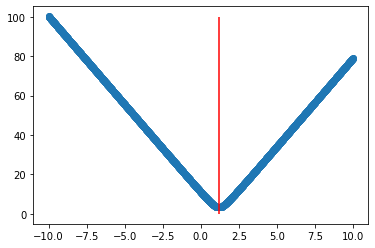

In [94]:
import matplotlib.pyplot as plt
plt.scatter(y = rmses, x = np.arange(-10,10,0.01))
plt.vlines(x = best, ymin = 0, ymax = 100, color = 'red')

In [95]:
best

1.1799999999997617

In [21]:
cal_key = {'outgoing_radiation_lw_set_1':'IR01DnCo_Avg','incoming_radiation_lw_set_1':'IR01UpCo_Avg','outgoing_radiation_sw_set_1':'SR01Up_Avg','solar_radiation_set_1':'SR01Dn_Avg'}
cals_dic = {}
diffs = []
for k, v in cal_key.items():
    best_cal = None
    diff_min = 1e10
    for cal in np.linspace(-5,5,1000):
        diff = np.nanmean((field_sub[k].values - data_sub[v].values * cal)**2)
        diffs.append(diff)
        if diff < diff_min:
            best_cal = cal
            diff_min = diff
    cals_dic[k] = best_cal    
    print(f'for {v} the calibration is {best_cal}')
            

ValueError: operands could not be broadcast together with shapes (45,) (47,) 

In [ ]:
import matplotlib.pyplot as plt
cal_key = {'outgoing_radiation_lw_set_1':'IR01DnCo_Avg','incoming_radiation_lw_set_1':'IR01UpCo_Avg','outgoing_radiation_sw_set_1':'SR01Up_Avg','solar_radiation_set_1':'SR01Dn_Avg'}
diffs = []
fig = px.line()
for k, v in cal_key.items():
    fig.add_trace(go.Scatter(x = data_sub.index, y = data_sub[v], name = v))
    fig.add_trace(go.Scatter(x = field_sub.index, y = field_sub[k], name = k))
    fig.add_trace(go.Scatter(x = data_sub.index, y = data_sub[v]*cals_dic[k], name = f'{v}corrected'))

fig.show()